Team Number: 4  

Group Members:
1. BRENDAN EDWARD RAJ,  
2. CHUA ZONG HAN LIONEL,  
3. JASBIR KAUR,  
4. KOH YAO HAO,  
5. TIANG SOON LONG,  
6. TOH ZHEN WEI

---







#Section 1: Introduction

## Problem Statement:

Accurately predicting football match outcomes has long been a challenge for analysts, bettors, and sports fans. Traditional prediction models rely on expert opinions, statistical trends, and historical performance, but these methods often fail to capture the complexity and dynamic nature of the game.

This project aims to explore the various machine learning models that predict football match outcomes based on historical match data, team statistics, and other relevant factors. By utilising modeling techniques, the objective is to enhance forecasting reliability and offer useful insights for analysts, teams, and even fans of the game.  


---



## About the Dataset:
### Dataset 1
The match data dataset contains 5,778 rows and 127 columns, representing match data from the Premier League (2017-2024).   
Each row corresponds to an individual match played by a team, including detailed match statistics, opponent information, and season-wise records.

Sample Columns in the Dataset
- Match Details: Date, Round, Day, Season
- Team Performance: Venue, Result (W/D/L), Goals For, Goals Against, Opponent
- Possession & Passing: Possession %, Passes Attempted, Passes Completed, Progressive Passes
- Shooting & Goals: Shots, Shots on Target, Expected Goals (xG), Goals
- Defensive Actions: Tackles, Interceptions, Blocks, Clearances
- Dribbling & Carrying: Successful Take-Ons, Carries into Final Third, Progressive Carries
---
### Dataset 2
The FIFA Team Rating Dataset is sourced from the FIFA video game series, which assigns numerical ratings to teams based on their in-game squad attributes. These ratings are influenced by real-world player performances and are regularly updated by EA Sports through squad updates. These updates reflect player transfers, form changes, ensuring that the ratings stay aligned with real-world football dynamics. This indirectly helps us quantify areas of football that are hard to be represented as values.

The dataset includes several important attributes for each team:
- Overall Rating: A single score summarizing the team's overall strength.
- Attack Rating: A measure of offensive capabilities, including finishing, pace, and dribbling.
- Midfield Rating: Reflects playmaking, passing, and control in the midfield.
- Defense Rating: Evaluates defensive organization, tackling, and positioning.



---


URL Links to Data Sources:
1. https://sofifa.com/teams
2. https://fbref.com/en/comps/9/Premier-League-Stats


# Section 2: Project Set Up
In this section, we will import the relevant libraries and also load the scrapped data we manually collected

### 2.1 Import Libraries and Load Dataset

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import timedelta

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

# Suppress performance warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
df = pd.read_csv("2017-2024 match data.csv")

In [3]:
fifa_game_team_rating_df= pd.read_csv("fifa_team_rating.csv")

# Section 3: Data Cleaning
In this section, we will conduct data cleaning and explore our data.

### 3.1 Fix Mismatched Team and Opponent Names

From the website we scrapped our data from, we realised that they had given some of the teams with different names, even though it was the same 1 team.

For example:  
Brighton and Hove Albion vs Brighton  
Manchester United vs Manchester Utd


We will correct the names so that the data is standardised and every team only has one name.

In [4]:
team_names = set(df["Team"].unique())
opponent_names = set(df["Opponent"].unique())

only_in_team = sorted(team_names - opponent_names)
only_in_opponent = sorted(opponent_names - team_names)

print("Names in 'Team' but not in 'Opponent':", only_in_team)
print("Names in 'Opponent' but not in 'Team':", only_in_opponent)

Names in 'Team' but not in 'Opponent': ['Brighton and Hove Albion', 'Huddersfield Town', 'Manchester United', 'Newcastle United', 'Nottingham Forest', 'Sheffield United', 'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United', 'Wolverhampton Wanderers']
Names in 'Opponent' but not in 'Team': ['Brighton', 'Huddersfield', 'Manchester Utd', 'Newcastle Utd', "Nott'ham Forest", 'Sheffield Utd', 'Tottenham', 'West Brom', 'West Ham', 'Wolves']


In [5]:
team_name_corrections = {
    "Brighton and Hove Albion": "Brighton",
    "Huddersfield Town": "Huddersfield",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",
}

df["Team"] = df["Team"].replace(team_name_corrections)

### 3.2 Checking for Missing Data

In [6]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Attendance    882
SoT%            3
G/Sh            3
G/SoT         184
Dist            3
npxG/Sh         3
Save%         169
dtype: int64


### 3.3 Handling Missing Data for SoT%, G/Sh, Dist and npxG/sh
Next, we investigate the data to understand why there are exactly 3 records missing for the following categories:

1. SoT% (Shots on Target %) = Percentage of shots that are on target  
2. G/Sh = Goals per shot taken  
3. Dist = Average Shot Distance  
4. npxG/sh = Non-Penalty Expected Goals per shot

Upon analysing the data and why there were missing values, we are confident that the website we scrapped the data from had mistakenly left it blank instead of '0.0'.   

How we realised this:

As the team had taken 0 shots, it would be impossible to have SoT% (Shots on Target %) or G/SoT (Goals per Shot on Target) - you can't produce any shot related metrics if a team doesn't take any shots

Thus, we will update the missing values in SoT%, G/Sh, Dist and npxG/Sh with 0

In [7]:
df['SoT%'] = df['SoT%'].fillna(0.0)
df['G/Sh'] = df['G/Sh'].fillna(0.0)
df['Dist'] = df['Dist'].fillna(0.0)
df['npxG/Sh'] = df['npxG/Sh'].fillna(0.0)

### 3.4 Handling Missing Data for Save% and G/SoT
The remaining columns of data to clean regarding missing data were: G/SoT and Save%, with 184 and 169 missing data points respectively.  

Similar to the previous step, we realised that the website we scrapped the data from had mistakenly left G/SoT and Save% blank.

Fixes Made for Save%:  
1. Ensure Save% is 0.0 when no shots were faced  
2. Compute Save% when SoTA > 0

Fixes Made for G/SoT:
1. G/SoT = 0.0 when SoT == 0 (No shots on target → No goals from shots on target)

In [8]:
df.loc[(df['SoTA'] == 0) & (df['Saves'] == 0), 'Save%'] = 0.0
df.loc[df['Save%'].isnull() & (df['SoTA'] > 0), 'Save%'] = (df['Saves'] / df['SoTA']) * 100
df.loc[df['SoT'] == 0, 'G/SoT'] = 0.0

### 3.5 Handling Missing Data for Attendance
Attendance has 882 missing datapoints, which makes up about 15% of our dataset.

Upon analysis and some research,  
2020-2021 Premier League season, many games had no attendance due to COVID-19 restrictions  
The no-fan period in the Premier League due to COVID-19 was mainly from:  
March 2020 – May 2021 (End of 2019-20 season & full 2020-21 season)  

First, we will check if there is any missing attendance outside covid period

In [9]:
# Convert Date column to DateTime
df["Date"] = pd.to_datetime(df["Date"])

covid_start = pd.to_datetime("2020-03-01")
covid_end = pd.to_datetime("2021-05-31")

df[df['Attendance'].isnull() & ~((df['Date'] >= covid_start) & (df['Date'] <= covid_end))]

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Progressive Carrying Distance,Progressive Carries,Carries into Final Third,Carries into Penalty Area,Miscontrols,Dispossessed,Passes Received,Progressive Passes Rec,Season,Team
4027,2023-05-28,16:30,Premier League,Matchweek 38,Sun,Away,L,1.0,2.0,Aston Villa,...,818.0,19.0,6.0,9.0,18.0,9.0,365.0,33.0,2022-2023,Brighton
4065,2023-05-28,16:30,Premier League,Matchweek 38,Sun,Home,W,2.0,1.0,Brighton,...,766.0,20.0,18.0,5.0,13.0,9.0,226.0,26.0,2022-2023,Aston Villa


From our code, we realised that there is 1 match with missing attendance data (2 records related to the same match)  
We will update attendance for missing attendance for Aston Villa vs Brighton using another reliable data source

Source: https://www.skysports.com/football/aston-villa-vs-brighton-and-hove-albion/stats/465006#:~:text=Aston%20Villa%20vs%20Brighton%20and,Villa%20ParkAttendance%3A%2042%2C212

In [10]:
df.loc[[4027, 4065], 'Attendance'] = 42212

For the remaining data which is still missing (covid games), we will replace the missing attendance with the team's median for that dataset  
We chose to use the median instead of setting it to 0 as it would mislead the machine learning model to identify false patterns and introduce bias in predictions.

In [11]:
# Step 1: Compute median attendance for each team when playing at home
home_medians = df[df['Venue'] == 'Home'].groupby('Team')['Attendance'].median()

# Step 2: Fill missing attendance for home games using their own home median
df.loc[(df['Attendance'].isnull()) & (df['Venue'] == 'Home'), 'Attendance'] = df['Team'].map(home_medians)

# Step 3: Fill remaining missing attendance for away games using the opponent's median (opponent is the home team)
df.loc[(df['Attendance'].isnull()) & (df['Venue'] == 'Away'), 'Attendance'] = df['Opponent'].map(home_medians)

We do a final check if there are any missing data remaining in the dataset. Empty output meaning no missing data in the dataset left.

In [12]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Series([], dtype: int64)


In [13]:
# Dropping columns which has no direct impact with outcome
df = df.drop(columns=['Captain', 'Formation', 'Opp Formation', 'Referee',"Time", "Day", "Comp", "Attendance"])

# Move 'Season' to index 4
cols = list(df.columns)
cols.insert(4, cols.pop(cols.index('Season')))
df = df[cols]

# Move 'Team' to the index 7
cols = list(df.columns)
cols.insert(7, cols.pop(cols.index('Team')))
df = df[cols]

### 3.6 FIFA Video Game Team Rating Dataset Cleaning

In [14]:
fifa_game_team_rating_df = fifa_game_team_rating_df[['Roster Date', 'Team Name', 'Overall Rating', 'Attack', 'Midfield', 'Defense']]
fifa_game_team_rating_df.head()

,Roster Date,Team Name,Overall Rating,Attack,Midfield,Defense
0,12/3/2025,Manchester City,85,85,85,83
1,12/3/2025,Liverpool,84,84,83,86
2,12/3/2025,Arsenal,83,81,85,81
3,12/3/2025,Aston Villa,81,82,80,80
4,12/3/2025,Chelsea,81,83,82,79


Cleaning the dataset by fixing mismatched team names, as team names will be the primary variable used to merge both datasets together

In [15]:
team_names = set(df["Team"].unique())
fifa_names = set(fifa_game_team_rating_df["Team Name"].unique())

only_in_team = sorted(team_names - fifa_names)
only_in_fifa = sorted(fifa_names - team_names)

print("Names in 'Team' but not in 'Fifa':", only_in_team)
print("Names in 'Fifa' but not in 'Team':", only_in_fifa)

Names in 'Team' but not in 'Fifa': ['Bournemouth', 'Brighton', 'Fulham', 'Huddersfield', 'Manchester Utd', 'Newcastle Utd', "Nott'ham Forest", 'Sheffield Utd', 'Tottenham', 'West Brom', 'West Ham', 'Wolves']
Names in 'Fifa' but not in 'Team': ['AFC Bournemouth', 'Brighton & Hove Albion', 'Fulham FC', 'Huddersfield Town', 'Hull City', 'Manchester United', 'Middlesbrough', 'Newcastle United', 'Nottingham Forest', 'Sheffield United', 'Sunderland', 'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United', 'Wolverhampton Wanderers']


In [16]:
fifa_team_name_corrections = {
    "AFC Bournemouth": "Bournemouth",
    "Brighton & Hove Albion": "Brighton",
    "Fulham FC": "Fulham",
    "Huddersfield Town": "Huddersfield",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",
}

fifa_game_team_rating_df["Team Name"] = fifa_game_team_rating_df["Team Name"].replace(fifa_team_name_corrections)

<ipython-input-16-1cd026c0b80d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fifa_game_team_rating_df["Team Name"] = fifa_game_team_rating_df["Team Name"].replace(fifa_team_name_corrections)


# Section 4: Exploratory Data Analysis (EDA)

### 4.1 Goal Distribution

Most matches have low goal counts, with 0, 1, or 2 goals being the most frequent.  
The distribution is right-skewed, meaning high-scoring matches are rare.

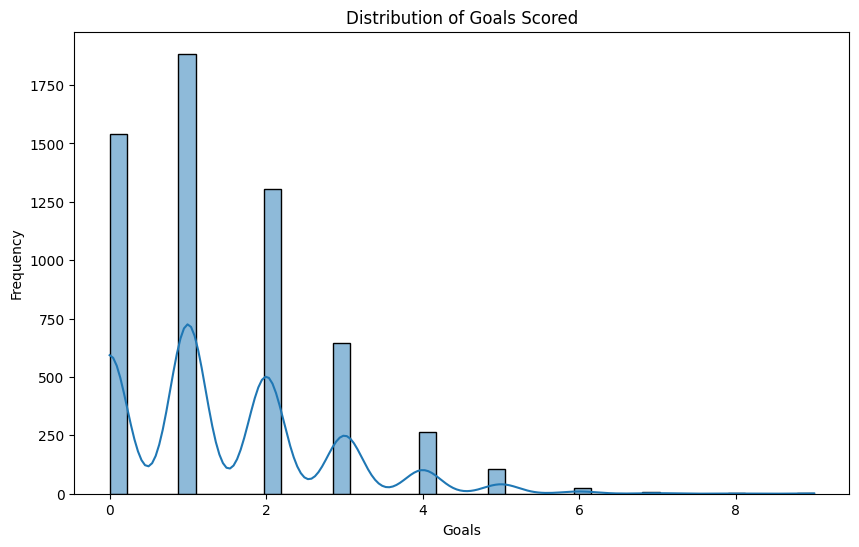

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df['GF'], kde=True)
plt.title('Distribution of Goals Scored')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.show()

### 4.2 Match Result Distribution  
In this dataset there is much more wins/losses than draws.  
Thus predicting draws may be harder.

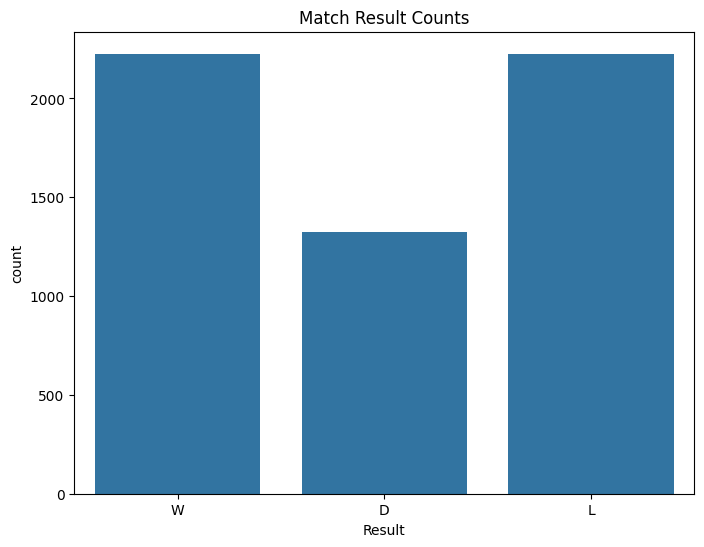

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Result', data=df)
plt.title('Match Result Counts')
plt.show()

### 4.3 Home vs. Away Performance:

Teams tend to perform better at home, with higher win counts compared to away games.  
Away matches have a higher frequency of losses, reinforcing the home advantage effect in football.

<Axes: xlabel='Venue', ylabel='count'>

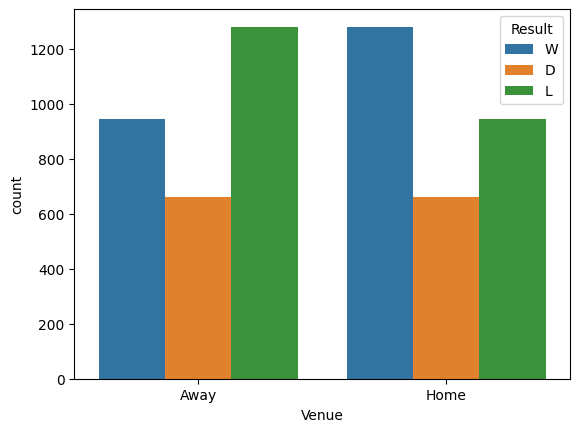

In [19]:
sns.countplot(x="Venue", hue="Result", data=df)

### 4.4 Feature Correlation

In machine learning, feature correlation analysis helps identify redundant or highly related variables to improve model efficiency and prevent overfitting.

When two features are 100% correlated, keeping both adds no additional value, so they can be removed.

Similarly, features with very high correlation (but not identical) often represent similar types of data, making one redundant (e.g., `"Live-ball Passes"` vs. `"Passes Received"`).

Additionally, domain knowledge plays a crucial role in feature selection, as some variables may have little to no impact on predicting football match outcomes (e.g., `"Throw-ins Taken"` and `"Corner Kick Types"`).

By systematically removing highly correlated and irrelevant features, the dataset is refined to include only unique and meaningful predictors, improving model interpretability and performance.

In [20]:
df_numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[df_numeric_cols].corr()

# Identify highly correlated features
threshold = 0.9
high_corr_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_features.append((col1, col2, corr_matrix.iloc[i, j]))

# Display highly correlated features
print("\nHighly Correlated Feature Pairs (Threshold = {}):".format(threshold))
for col1, col2, corr_value in sorted(high_corr_features, key=lambda x: -abs(x[2])):
    print(f"{col1} ⟷ {col2} | Correlation: {corr_value:.2f}")


Highly Correlated Feature Pairs (Threshold = 0.9):
Passes Attempted ⟷ Total_Att | Correlation: 1.00
Passes Completed ⟷ Total_Cmp | Correlation: 1.00
Possession % ⟷ Poss | Correlation: 1.00
Touches (Live-Ball) ⟷ Touches | Correlation: 1.00
Passes Received ⟷ Total_Cmp | Correlation: 1.00
Passes Received ⟷ Passes Completed | Correlation: 1.00
Progressive Passes Rec ⟷ PrgP | Correlation: 1.00
Live-ball Passes ⟷ Total_Att | Correlation: 1.00
Live-ball Passes ⟷ Passes Attempted | Correlation: 1.00
Short Pass Att ⟷ Short Pass Cmp | Correlation: 1.00
Medium Pass Att ⟷ Medium Pass Cmp | Correlation: 0.99
Live-ball Passes ⟷ Total_Cmp | Correlation: 0.99
Passes Completed ⟷ Live-ball Passes | Correlation: 0.99
Passes Received ⟷ Live-ball Passes | Correlation: 0.99
Touches ⟷ Total_Att | Correlation: 0.99
Touches ⟷ Passes Attempted | Correlation: 0.99
Touches (Live-Ball) ⟷ Total_Att | Correlation: 0.99
Touches (Live-Ball) ⟷ Passes Attempted | Correlation: 0.99
Touches ⟷ Live-ball Passes | Correlati

In [21]:
# Drop columns that have the another column in the df that represents the exact same kind of data (100% correlation)
df = df.drop(columns=['Total_Att', 'Total_Cmp', 'Poss', 'Touches',"Passes Received", "PrgP"])

# Drop columns that have very high correlation to other columns in the DF/ represent very similar data
df = df.drop(columns=['np:G-xG',  'Long Pass Att', 'Medium Pass Att', 'Short Pass Att','Touches (Live-Ball)','Live-ball Passes','Dead-ball Passes','Progressive Carrying Distance','Progressive Carries','GCA','Total_TotDist','Take-Ons Attempted','Passes Blocked_x','Dribblers Tackled'])

# Drop columns based on domain knowledge that these columns have no direct relation to predicting outcome of football matches
df = df.drop(columns=['Switches','Throw-ins Taken','Outswinging Corner Kicks','Inswinging Corner Kick','Straight Corner Kicks', 'SCA','SCA (Live-ball Pass)','SCA (Dead-ball Pass)', 'SCA (Take-On)', 'SCA (Shot)', 'SCA (Fouls Drawn)', 'SCA (Defensive Action)',
                     'Touches (Def Pen)',	'Touches (Def 3rd)',	'Touches (Mid 3rd)','Tackles (Att 3rd)'])


# Section 5: Data and Feature Engineering

### 5.1 Data Engineering: Merging FIFA Game Team Ratings with Match Dataset

In [22]:
# Ensure Date columns are in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
fifa_game_team_rating_df['Roster Date'] = pd.to_datetime(fifa_game_team_rating_df['Roster Date'], format='%d/%m/%Y')

# Sort data by date (VERY IMPORTANT for merge_asof)
df = df.sort_values(by='Date')
fifa_game_team_rating_df = fifa_game_team_rating_df.sort_values(by='Roster Date')

# Merge FIFA ratings for each team (backward to ensure no future data is leaked)
df = pd.merge_asof(
    df,
    fifa_game_team_rating_df,
    left_on='Date',
    right_on='Roster Date',
    left_by='Team',  # Match Team in df with Team Name in fifa_game_team_rating_df
    right_by='Team Name',
    direction='backward'  # Ensures only past data is used
)

# Rename merged columns for the Team
df = df.rename(columns={
    'Overall Rating': 'FIFA Overall Rating',
    'Attack': 'FIFA Attack Rating',
    'Midfield': 'FIFA Midfield Rating',
    'Defense': 'FIFA Defense Rating'
})

# Merge FIFA ratings for the Opponent (backward to prevent data leakage)
df = pd.merge_asof(
    df,
    fifa_game_team_rating_df,
    left_on='Date',
    right_on='Roster Date',
    left_by='Opponent',  # Match Opponent in df with Team Name in fifa_game_team_rating_df
    right_by='Team Name',
    direction='backward'  # Ensures only past data is used
)

# Rename merged columns for the Opponent
df = df.rename(columns={
    'Overall Rating': 'Opponent FIFA Overall Rating',
    'Attack': 'Opponent FIFA Attack Rating',
    'Midfield': 'Opponent FIFA Midfield Rating',
    'Defense': 'Opponent FIFA Defense Rating'
})

# Drop unnecessary columns
df = df.drop(columns=['Roster Date_x', 'Team Name_x','Roster Date_y', 'Team Name_y'])
df.head()

,Date,Round,Venue,Result,Season,GF,GA,Team,Opponent,xG,...,Dispossessed,Progressive Passes Rec,FIFA Overall Rating,FIFA Attack Rating,FIFA Midfield Rating,FIFA Defense Rating,Opponent FIFA Overall Rating,Opponent FIFA Attack Rating,Opponent FIFA Midfield Rating,Opponent FIFA Defense Rating
0,2017-08-11,Matchweek 1,Home,W,2017-2018,4.0,3.0,Arsenal,Leicester City,2.5,...,14.0,61.0,83,81,83,82,78,79,78,76
1,2017-08-11,Matchweek 1,Away,L,2017-2018,3.0,4.0,Leicester City,Arsenal,1.5,...,12.0,16.0,78,79,78,76,83,81,83,82
2,2017-08-12,Matchweek 1,Away,W,2017-2018,2.0,0.0,Manchester City,Brighton,1.9,...,4.0,87.0,83,83,85,81,72,72,73,73
3,2017-08-12,Matchweek 1,Away,W,2017-2018,3.0,2.0,Burnley,Chelsea,0.6,...,9.0,25.0,74,74,74,76,83,86,84,81
4,2017-08-12,Matchweek 1,Away,D,2017-2018,3.0,3.0,Liverpool,Watford,2.6,...,14.0,40.0,81,82,81,81,77,78,78,76


Creating a copy of the cleaned df and assigning it as df_w_features so that it can be used for Feature Engineering

In [23]:
df_w_features= df.copy()

### 5.2 Feature: Home Advantage
Encoding home advantage as a binary variable (1 if the match is played at home, 0 otherwise).   

This feature can be useful for our classification model, as playing at home is often associated with higher chances of winning due to factors like crowd support, familiarity with the pitch, and reduced travel fatigue.

In [24]:
df_w_features['Venue_Home'] = (df_w_features['Venue'] == 'Home').astype(int)

### 5.3 Feature: Performance-Based Comparative Metrics
These features capture a team's dominance over its opponents in various aspects, such as goal difference, expected goals (xG), shots on target (SoT), and possession.

They provide insights into a team's attacking and defensive strengths. However, since they rely on match outcomes, using them directly for predictions could lead to data leakage. Instead, they will be used later on as rolling averages to reflect team trends over time without leaking future results.

In [25]:
def calculate_goal_difference(df):
    df["Goal_Diff"] = df["GF"] - df["GA"]
    return df

def calculate_xg_difference(df):
    df["xG_Difference"] = df["xG"] - df["xGA"]
    return df

def calculate_sot_difference(df):
    df["SoT_Difference"] = df["SoT"] - df["SoTA"]
    return df

def calculate_possession_difference(df):
    df["Opponent_Possession"] = 100 - df["Possession %"]
    df["Poss_Diff"] = df["Possession %"] - df["Opponent_Possession"]
    return df

### 5.4 Feature: Form-Based Features
These features quantify a team's recent performance by tracking past match results, points earned, and streaks. They include rolling average points over the last 5 matches, direct form comparisons with opponents, encoded past match sequences, and unbeaten streaks.

These metrics highlight a team's consistency and momentum, helping predict future performance trends. Since they rely on past results, they are structured to avoid data leakage by using only information available before each match.

Summary of functions:
1. `calculate_form_comparison(df)`  
  - Calculates: The difference in rolling average points (last 5 matches) between a team and its opponent.
  - Feature Value: Captures recent performance trends, helping assess which team has stronger momentum leading into the match.
2. `calculate_form_pattern(df, N=5)`
  - Calculates: A sequence of the team's last N match results (e.g., "WWLDW").
  - Feature Value: Provides historical performance context, helping detect winning/losing streaks or patterns.
  - Works with: `convert_form_pattern_to_numerical(df, N=5)` to transform categorical match sequences into numerical values.
3. `convert_form_pattern_to_numerical(df, N=5)`
  - Calculates: Converts the past N match results from `calculate_form_pattern()` into numerical values (Win = 1, Draw = 0, Loss = -1).
  - Feature Value: Transforms historical performance into a numeric format that machine learning models can interpret effectively.
4. `calculate_unbeaten_streak_before_match(df)`
  - Calculates: The number of consecutive matches a team has gone without losing before a match.
  - Feature Value: Highlights team consistency and resilience, indicating whether a team is on an unbeaten run or struggling.

5. `calculate_clean_sheet_percentage(df, N=5)`
  - Calculates: The percentage of clean sheets in the last N matches before a given match.
  - Feature Value: Captures short-term defensive consistency. Helps measure whether a team is in strong defensive form or struggling to keep clean sheets.

In [26]:
def calculate_form_comparison(df):
    df = df.sort_values(["Team", "Date"])
    df["Points_Earned"] = df["Result"].map({"W": 3, "D": 1, "L": 0})

    df["Team_Last_5_Avg_Points"] = df.groupby("Team")["Points_Earned"].shift(1).rolling(5).mean()

    # Merge with opponent's last 5 avg points
    df = df.merge(df[["Team", "Date", "Team_Last_5_Avg_Points"]],
                  left_on=["Opponent", "Date"],
                  right_on=["Team", "Date"],
                  suffixes=("", "_Opponent")).drop(columns=["Team_Opponent"], errors='ignore')

    df.rename(columns={"Team_Last_5_Avg_Points_Opponent": "Opponent_Last_5_Avg_Points"}, inplace=True)

    df["Last_5_Points_Comparison"] = df["Team_Last_5_Avg_Points"] - df["Opponent_Last_5_Avg_Points"]

    df.drop(columns=["Points_Earned"], inplace=True)

    return df

def calculate_form_pattern(df, N=5):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    form_patterns = []

    for team in df["Team"].unique():
        team_results = df[df["Team"] == team]["Result"].tolist()
        team_form = []

        for i in range(len(team_results)):
            if i == 0:
                team_form.append("")  # First match has no history
            else:
                # Extract last N results before current match
                start_idx = max(0, i - N)  # Ensure index doesn't go negative
                form_str = "".join(team_results[start_idx:i])  # Join past results into string
                team_form.append(form_str)

        form_patterns.extend(team_form)

    df["Form_Pattern_Before_Match"] = form_patterns

    return df

def convert_form_pattern_to_numerical(df, N=5):
    # Ensure column exists
    if "Form_Pattern_Before_Match" not in df.columns:
        print("Error: Form_Pattern_Before_Match column not found.")
        return df

    # Convert last N match results into separate numerical features
    for i in range(1, N+1):
        df[f"Form_{i}"] = df["Form_Pattern_Before_Match"].apply(lambda x: x[-i] if len(x) >= i else "None")

    # Map W/D/L to numerical values
    mapping = {"W": 1, "D": 0, "L": -1, "None": 0}
    for i in range(1, N+1):
        df[f"Form_{i}"] = df[f"Form_{i}"].map(mapping)

    df.drop(columns=["Form_Pattern_Before_Match"], inplace=True)

    return df

def calculate_unbeaten_streak_before_match(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    unbeaten_streak = []

    for team in df["Team"].unique():
        team_results = df[df["Team"] == team]["Result"].tolist()
        streak = 0
        team_streak = []

        for result in team_results:
            team_streak.append(streak)
            if result in ["W", "D"]:
                streak += 1
            else:
                streak = 0

        unbeaten_streak.extend(team_streak)

    df["Unbeaten_Streak_Before_Match"] = unbeaten_streak

    return df

def calculate_clean_sheet_percentage(df, N=5):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    df["Last_5_Clean_Sheet_Percentage"] = (
        df.groupby("Team")["CS"]
        .apply(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
        .reset_index(drop=True)
    )

    return df

### 5.5 Feature: Season Performance Metrics
Understanding a team's long-term performance trends is crucial in predicting match outcomes. These features track a team's progress throughout the season by analyzing cumulative points, ranking, and comparative strength against opponents.  

By incorporating historical data, they provide insights into how consistently a team has performed and whether it is in good form or struggling. These metrics help identify title contenders, relegation risks, or mid-table teams and serve as a baseline for evaluating match expectations.

The following functions calculate seasonal performance indicators that ensure only past match data is considered, avoiding data leakage while providing useful context for predictive modeling.

Summary of functions:
1. `calculate_season_points(df)`
  - Calculates: Cumulative points earned before each match.
  - Feature Value: Represents a team's progress throughout the season.

2. `calculate_opponent_season_points(df)`
  - Calculates: The opponent’s cumulative season points before the match.
  - Feature Value: Helps compare team strength based on season-long performance.

3. `calculate_season_points_comparison(df)`
  - Calculates: The difference in season points before the match, between the team and its opponent.
  - Feature Value: Highlights the relative strength of both teams leading into the match.

4. `calculate_season_ranking(df)`
  - Calculates: Season ranking before each match, based on cumulative points.
  - Feature Value: Provides a dynamic measure of league standing and relative positioning.

5. `calculate_season_goal_difference(df)`
  - Calculates: A team's cumulative goal difference before each match in the season.
  - Feature Value: Reflects attacking and defensive efficiency over the season Also helps to assess whether a team has consistently outscored opponents or struggled defensively, and provides context on long-term performance rather than short-term fluctuations.

In [27]:
# Define a function to calculate season points earned before each match
def calculate_season_points(df):
    points_mapping = {"W": 3, "D": 1, "L": 0}

    df["Match_Points"] = df["Result"].map(points_mapping)
    df["Date"] = pd.to_datetime(df["Date"])

    df = df.sort_values(["Team", "Season", "Date"])
    df["Team_Season_Points_Before_Match"] = df.groupby(["Team", "Season"])["Match_Points"].cumsum().shift(1).fillna(0)
    df.loc[df["Round"] == "Matchweek 1", "Team_Season_Points_Before_Match"] = 0
    df.drop(columns=["Match_Points"], inplace=True)

    return df


def calculate_opponent_season_points(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Season", "Date"])

    df = df.merge(
        df[["Team", "Season", "Date", "Team_Season_Points_Before_Match"]],
        left_on=["Opponent", "Season", "Date"],
        right_on=["Team", "Season", "Date"],
        suffixes=("", "_Opponent")
    )

    df = df.rename(columns={"Team_Season_Points_Before_Match_Opponent": "Opponent_Season_Points_Before_Match"})
    df.drop(columns=["Team_Opponent"], errors='ignore', inplace=True)

    return df

def calculate_season_points_comparison(df):
    df["Season_Points_Comparison_Before_Match"] = df["Team_Season_Points_Before_Match"] - df["Opponent_Season_Points_Before_Match"]

    return df

def calculate_season_ranking(df):
    # Rank teams based on season points before each match (lower rank = higher position)
    df["Team_Season_Rank"] = df.groupby(["Season", "Date"])["Team_Season_Points_Before_Match"].rank(ascending=False, method="min")

    df = df.merge(df[["Team", "Season", "Date", "Team_Season_Rank"]],
                  left_on=["Opponent", "Season", "Date"],
                  right_on=["Team", "Season", "Date"],
                  suffixes=("", "_Opponent")).drop(columns=["Team_Opponent"], errors='ignore')

    df.rename(columns={"Team_Season_Rank_Opponent": "Opponent_Season_Rank"}, inplace=True)
    df["Rank_Comparison"] = df["Opponent_Season_Rank"] - df["Team_Season_Rank"]

    return df

def calculate_season_goal_difference(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Season", "Date"])

    # Compute cumulative goal difference per season for each team (before the match)
    df["Team_Goal_Difference_Before_Match"] = df.groupby(["Team", "Season"])["Goal_Diff"].cumsum().shift(1).fillna(0)

    df.loc[df["Round"] == "Matchweek 1", "Team_Goal_Difference_Before_Match"] = 0

    df = df.merge(
        df[["Team", "Season", "Date", "Team_Goal_Difference_Before_Match"]],
        left_on=["Opponent", "Season", "Date"],
        right_on=["Team", "Season", "Date"],
        suffixes=("", "_Opponent")
    )

    df.rename(columns={"Team_Goal_Difference_Before_Match_Opponent": "Opponent_Goal_Difference_Before_Match"}, inplace=True)
    df["Goal_Difference_Comparison_Before_Match"] = df["Team_Goal_Difference_Before_Match"] - df["Opponent_Goal_Difference_Before_Match"]
    df.drop(columns=["Team_Opponent"], errors='ignore', inplace=True)

    return df

### 5.6 Feature: Venue-Based Performance Trends
`calculate_home_away_performance(df, N=5)` measures how a team performs differently at home vs. away.

  - Calculates: Rolling average points per match at home vs. away.
  - Feature Value: Highlights a team's home advantage or away struggles.

Includes:
- `Home_Points_Per_Match` → Average points earned at home over last N games.
- `Away_Points_Per_Match` → Average points earned away over last N games.
- `Home_Away_Performance_Diff` → Difference between home & away performance.
- `Venue_Adjusted_Points_Per_Match` → Expected points based on venue.

In [28]:
def calculate_home_away_performance(df, N=5):
    df = df.sort_values(["Team", "Date"])
    df["Points_Earned"] = df["Result"].map({"W": 3, "D": 1, "L": 0})

    df["Home_Points_Earned"] = np.where(df["Venue"] == "Home", df["Points_Earned"], np.nan)
    df["Away_Points_Earned"] = np.where(df["Venue"] == "Away", df["Points_Earned"], np.nan)

    df["Home_Points_Per_Match"] = (
      df.groupby("Team")["Home_Points_Earned"]
      .transform(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
      .ffill()
      )

    df["Away_Points_Per_Match"] = (
        df.groupby("Team")["Away_Points_Earned"]
        .transform(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
        .ffill()
    )

    df["Home_Away_Performance_Diff"] = df["Home_Points_Per_Match"] - df["Away_Points_Per_Match"]

    df["Venue_Adjusted_Points_Per_Match"] = np.where(
        df["Venue"] == "Home",
        df["Home_Points_Per_Match"],
        df["Away_Points_Per_Match"]
    )

    return df

### 5.7 Feature: Head-to-Head Performance Metrics
In football, past encounters between two teams can be a strong indicator of future match outcomes. Some teams consistently outperform others due to tactical advantages, psychological factors, or historical dominance. The Head-to-Head (H2H) Performance Metrics capture these trends by analyzing the most recent encounters between two teams. This information helps identify patterns such as a team having a winning streak over a specific opponent, a history of closely contested matches, or frequent draws.


`calculate_head_to_head_record(df, N=4)`
  - Calculates:
    - The number of wins, draws, and losses in the last N matches between two teams.
    - The total number of H2H matches played before the current game.
    - The win percentage against the opponent over the last N encounters.
  - Feature Value:
Identifies historical dominance or weakness against a specific opponent.
Highlights whether a team is on a winning streak or struggling in recent H2H meetings.

In [29]:
def calculate_head_to_head_record(df, N=4):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Date"])

    # Create a copy of the dataframe to hold the results
    result_df = df.copy()

    # Initialize H2H columns
    result_df["H2H_Wins"] = 0
    result_df["H2H_Draws"] = 0
    result_df["H2H_Losses"] = 0
    result_df["H2H_Total_Matches"] = 0
    result_df["H2H_Win_Percentage"] = 0.0

    # Process each match
    for idx, current_match in result_df.iterrows():
        team = current_match["Team"]
        opponent = current_match["Opponent"]
        match_date = current_match["Date"]

        historical_matches = df[
            (df["Date"] < match_date) &
            (df["Team"] == team) &
            (df["Opponent"] == opponent)
        ]

        last_n_matches = historical_matches.tail(N)

        if not last_n_matches.empty:
            h2h_wins = last_n_matches[last_n_matches["Result"] == "W"].shape[0]
            h2h_draws = last_n_matches[last_n_matches["Result"] == "D"].shape[0]
            h2h_losses = last_n_matches[last_n_matches["Result"] == "L"].shape[0]

            h2h_total = h2h_wins + h2h_draws + h2h_losses
            h2h_win_pct = h2h_wins / h2h_total if h2h_total > 0 else 0.0

            result_df.at[idx, "H2H_Wins"] = h2h_wins
            result_df.at[idx, "H2H_Draws"] = h2h_draws
            result_df.at[idx, "H2H_Losses"] = h2h_losses
            result_df.at[idx, "H2H_Total_Matches"] = h2h_total
            result_df.at[idx, "H2H_Win_Percentage"] = h2h_win_pct

    return result_df

### 5.8 Feature: FIFA Game Ratings
The FIFA Game Ratings feature leverages team ratings from the FIFA video game series, which assigns numerical ratings to teams based on their in-game attributes. These ratings reflect real-world player performances, team balance, and squad depth.

This feature extracts rating differences between a team and its opponent, highlighting disparities in overall squad strength, attacking power, midfield control, and defensive solidity. By incorporating these differences, models can assess whether a team has a significant advantage or disadvantage in key areas of the pitch.

`calculate_fifa_rating_diffs(df)`
- Calculates:
  - The overall rating difference between the team and its opponent.
  - The attack rating difference, which measures the disparity in offensive strength.
  - The midfield rating difference, reflecting control in playmaking and ball distribution.
  - The defense rating difference, indicating variations in defensive capabilities.
- Feature Value:
The FIFA rating differences quantify team strength disparities and serve as a predictive indicator of match outcomes. Higher positive values suggest a stronger team relative to its opponent, while negative values indicate a weaker squad.

In [30]:
def create_fifa_features(df):
    # Overall, Attack, Midfield, and Defense rating differences
    df['FIFA Overall Rating Diff'] = df['FIFA Overall Rating'] - df['Opponent FIFA Overall Rating']
    df['FIFA Attack Rating Diff'] = df['FIFA Attack Rating'] - df['Opponent FIFA Attack Rating']
    df['FIFA Midfield Rating Diff'] = df['FIFA Midfield Rating'] - df['Opponent FIFA Midfield Rating']
    df['FIFA Defense Rating Diff'] = df['FIFA Defense Rating'] - df['Opponent FIFA Defense Rating']

    return df

Apply functions of the features we engineered into the dataframe, and encoding the Target Variable ( the `Result` column) for Classification. This is necessary because most ML models only work with numerical data.

In [31]:
# Apply functions
df_w_features = calculate_goal_difference(df_w_features)
df_w_features = calculate_xg_difference(df_w_features)
df_w_features = calculate_sot_difference(df_w_features)
df_w_features = calculate_possession_difference(df_w_features)
df_w_features = calculate_form_comparison(df_w_features)
df_w_features = calculate_form_pattern(df_w_features)
df_w_features = convert_form_pattern_to_numerical(df_w_features)
df_w_features = calculate_unbeaten_streak_before_match(df_w_features)
df_w_features = calculate_season_points(df_w_features)
df_w_features = calculate_opponent_season_points(df_w_features)
df_w_features = calculate_season_points_comparison(df_w_features)
df_w_features = calculate_season_goal_difference(df_w_features)
df_w_features = calculate_head_to_head_record(df_w_features)
df_w_features = calculate_clean_sheet_percentage(df_w_features)
df_w_features = calculate_season_ranking(df_w_features)
df_w_features = calculate_home_away_performance(df_w_features)
df_w_features = create_fifa_features(df_w_features)

# Encode Target Variable
le = LabelEncoder()
df_w_features['Result'] = le.fit_transform(df_w_features['Result'])

df_w_features.tail()

,Date,Round,Venue,Result,Season,GF,GA,Team,Opponent,xG,...,Home_Points_Earned,Away_Points_Earned,Home_Points_Per_Match,Away_Points_Per_Match,Home_Away_Performance_Diff,Venue_Adjusted_Points_Per_Match,FIFA Overall Rating Diff,FIFA Attack Rating Diff,FIFA Midfield Rating Diff,FIFA Defense Rating Diff
5773,2024-12-29,Matchweek 19,Away,0,2024-2025,2.0,2.0,Wolves,Tottenham,0.7,...,NaN,1.0,1.5,1.000000,0.500000,1.000000,-4,-5,-5,-2
5774,2025-01-06,Matchweek 20,Home,1,2024-2025,0.0,3.0,Wolves,Nott'ham Forest,1.5,...,0.0,NaN,1.5,1.333333,0.166667,1.500000,0,-1,-1,-1
5775,2025-01-15,Matchweek 21,Away,1,2024-2025,0.0,3.0,Wolves,Newcastle Utd,1.6,...,NaN,0.0,1.0,2.000000,-1.000000,2.000000,-4,-3,-8,-3
5776,2025-01-20,Matchweek 22,Away,1,2024-2025,1.0,3.0,Wolves,Chelsea,0.8,...,NaN,0.0,1.5,1.333333,0.166667,1.333333,-5,-4,-6,-3
5777,2025-01-25,Matchweek 23,Home,1,2024-2025,0.0,1.0,Wolves,Arsenal,0.7,...,0.0,NaN,1.5,0.333333,1.166667,1.500000,-8,-3,-9,-7


## 5.9 Feature: Calculating the Rolling Averages of in game statistics.
Selecting numeric features from `df_w_features` to apply rolling averages, as rolling averages can’t be applied to categorical/text features.  

The second line of code removes certain features from the rolling averages calculation.
Features like `"Result"`, `"Venue_Home"`, and "`H2H_Wins"` are excluded because:
- Some are categorical (e.g., `"Result"`, `"Venue_Home"`).
- Others are already rolling averages (e.g., `"Last_5_Avg_Points"`).
- Some are pre-calculated metrics that don’t require further smoothing (e.g., `"Rank_Comparsion"`).

Rolling averages help smooth out variations and prevent data leakage by ensuring that only historical data is used for predictions.

In [32]:
# Select numeric columns only as rolling averages can only be done on numeric columns
df_w_features_numeric_cols = df_w_features.select_dtypes(include=np.number).columns

# Specify the features that will have the rolling average function applied to them by dropping the features that do not need rolling averages
rolling_features = df_w_features_numeric_cols.drop(['Result', 'Venue_Home', 'FIFA Overall Rating', 'FIFA Attack Rating','FIFA Midfield Rating', 'FIFA Defense Rating', 'Opponent FIFA Overall Rating','Opponent FIFA Attack Rating','Opponent FIFA Midfield Rating','Opponent FIFA Defense Rating',
                                                    "FIFA Overall Rating Diff", "FIFA Attack Rating Diff", "FIFA Midfield Rating Diff", "FIFA Defense Rating Diff",
                                                    'Team_Last_5_Avg_Points',	'Opponent_Last_5_Avg_Points',	'Last_5_Points_Comparison', 'Form_1', 'Form_2', 'Form_3', 'Form_4', 'Form_5', 'Unbeaten_Streak_Before_Match',	'Team_Season_Points_Before_Match',	'Opponent_Season_Points_Before_Match',
                                                    'Season_Points_Comparison_Before_Match',	'Team_Goal_Difference_Before_Match',	'Opponent_Goal_Difference_Before_Match',	'Goal_Difference_Comparison_Before_Match',	'H2H_Wins',	'H2H_Draws',
                                                    'H2H_Losses',	'H2H_Total_Matches',	'H2H_Win_Percentage',	'Last_5_Clean_Sheet_Percentage',	'Team_Season_Rank',	'Opponent_Season_Rank',	'Rank_Comparison', 'Points_Earned',	'Home_Points_Earned',
                                                    'Away_Points_Earned',	'Home_Points_Per_Match',	'Away_Points_Per_Match',	'Home_Away_Performance_Diff',	'Venue_Adjusted_Points_Per_Match'], errors='ignore')

In [33]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(5, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [34]:
# Use the previously specified columns (rolling_features) to have Rolling Average function applied and set a standard name format for the new columns created
cols = list(rolling_features)
new_cols = [f"{c}_Rolling_Avg" for c in cols]

In [35]:
# Apply Rolling Average Function
df_w_rolling_features = df_w_features.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))
df_w_rolling_features = df_w_rolling_features.droplevel('Team')

# Reset Index
df_w_rolling_features.index = range(df_w_rolling_features.shape[0])

# Drop all rows with NaN for Last_5_Avg_Points_Opponent, due to newly promoted teams with no history
df_w_rolling_features = df_w_rolling_features.dropna(subset=["Opponent_Last_5_Avg_Points"]).reset_index(drop=True)

# Create DF to specify columns that we are not allowed to use, to prevent data leakage
invalid_cols = df_w_features.columns[1:83].tolist()

# Keep 'Result' (index 3)
invalid_cols = [col for col in invalid_cols if col not in [df_w_features.columns[3]]]

#
invalid_cols.extend([df_w_features.columns[92],df_w_features.columns[93],df_w_features.columns[94],df_w_features.columns[95],df_w_features.columns[96],df_w_features.columns[121],df_w_features.columns[122],df_w_features.columns[123]])

# Drop the invalid columns
df_w_rolling_features = df_w_rolling_features.drop(columns=invalid_cols, axis=1)

pd.set_option("display.max_columns", None)
df_w_rolling_features.head(10)

<ipython-input-35-988410a42257>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_w_rolling_features = df_w_features.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))


,Date,Result,FIFA Overall Rating,FIFA Attack Rating,FIFA Midfield Rating,FIFA Defense Rating,Opponent FIFA Overall Rating,Opponent FIFA Attack Rating,Opponent FIFA Midfield Rating,Opponent FIFA Defense Rating,Venue_Home,Team_Last_5_Avg_Points,Opponent_Last_5_Avg_Points,Last_5_Points_Comparison,Form_1,Form_2,Form_3,Form_4,Form_5,Unbeaten_Streak_Before_Match,Team_Season_Points_Before_Match,Opponent_Season_Points_Before_Match,Season_Points_Comparison_Before_Match,Team_Goal_Difference_Before_Match,Opponent_Goal_Difference_Before_Match,Goal_Difference_Comparison_Before_Match,H2H_Wins,H2H_Draws,H2H_Losses,H2H_Total_Matches,H2H_Win_Percentage,Last_5_Clean_Sheet_Percentage,Team_Season_Rank,Opponent_Season_Rank,Rank_Comparison,Home_Points_Per_Match,Away_Points_Per_Match,Home_Away_Performance_Diff,Venue_Adjusted_Points_Per_Match,FIFA Overall Rating Diff,FIFA Attack Rating Diff,FIFA Midfield Rating Diff,FIFA Defense Rating Diff,GF_Rolling_Avg,GA_Rolling_Avg,xG_Rolling_Avg,xGA_Rolling_Avg,Sh_Rolling_Avg,SoT_Rolling_Avg,SoT%_Rolling_Avg,G/Sh_Rolling_Avg,G/SoT_Rolling_Avg,Dist_Rolling_Avg,FK_Rolling_Avg,PK_Rolling_Avg,PKatt_Rolling_Avg,npxG_Rolling_Avg,npxG/Sh_Rolling_Avg,G-xG_Rolling_Avg,SoTA_Rolling_Avg,Saves_Rolling_Avg,Save%_Rolling_Avg,CS_Rolling_Avg,Total_Cmp%_Rolling_Avg,Total_PrgDist_Rolling_Avg,Short Pass Cmp_Rolling_Avg,Short Pass Cmp%_Rolling_Avg,Medium Pass Cmp_Rolling_Avg,Medium Pass Cmp%_Rolling_Avg,Long Pass Cmp_Rolling_Avg,Long Pass Cmp%_Rolling_Avg,Ast_Rolling_Avg,xAG_Rolling_Avg,xA_Rolling_Avg,KP_Rolling_Avg,1/3_Rolling_Avg,PPA_Rolling_Avg,CrsPA_Rolling_Avg,Passes Attempted_Rolling_Avg,Passes from Free Kicks_Rolling_Avg,Through Balls_Rolling_Avg,Crosses_Rolling_Avg,Corner Kicks_Rolling_Avg,Passes Completed_Rolling_Avg,Passes Offside_Rolling_Avg,GCA (Live-ball Pass)_Rolling_Avg,GCA (Dead-ball Pass)_Rolling_Avg,GCA (Take-On)_Rolling_Avg,GCA (Shot)_Rolling_Avg,GCA (Fouls Drawn)_Rolling_Avg,GCA (Defensive Action)_Rolling_Avg,Tackles_Rolling_Avg,Tackles Won_Rolling_Avg,Tackles (Def 3rd)_Rolling_Avg,Tackles (Mid 3rd)_Rolling_Avg,Dribbles Challenged_Rolling_Avg,% of Dribblers Tackled_Rolling_Avg,Challenges Lost_Rolling_Avg,Blocks _Rolling_Avg,Shots Blocked_Rolling_Avg,Passes Blocked_y_Rolling_Avg,Interceptions_Rolling_Avg,Tkl+Int_Rolling_Avg,Clearances_Rolling_Avg,Errors_Rolling_Avg,Possession %_Rolling_Avg,Touches (Att 3rd)_Rolling_Avg,Touches (Att Pen)_Rolling_Avg,Successful Take-Ons _Rolling_Avg,Successful Take-On %_Rolling_Avg,Times Tackled During Take-On_Rolling_Avg,Tackled During Take-On Percentage_Rolling_Avg,Carries _Rolling_Avg,Total Carrying Distance_Rolling_Avg,Carries into Final Third_Rolling_Avg,Carries into Penalty Area_Rolling_Avg,Miscontrols_Rolling_Avg,Dispossessed_Rolling_Avg,Progressive Passes Rec_Rolling_Avg,Goal_Diff_Rolling_Avg,xG_Difference_Rolling_Avg,SoT_Difference_Rolling_Avg,Opponent_Possession_Rolling_Avg,Poss_Diff_Rolling_Avg
0,2017-09-25,2,83,86,82,81,77,80,77,76,1,1.4,1.6,-0.2,0,1,-1,-1,1,2,7.0,8.0,-1.0,-1.0,0.0,-1.0,0,0,0,0,0.0,0.4,2.0,1.0,-1.0,3.0,0.333333,2.666667,3.0,6,6,5,5,1.4,1.6,1.64,1.34,16.2,5.4,28.28,0.066,0.146,17.50,0.2,0.0,0.0,1.64,0.104,-0.24,4.6,3.0,67.00,0.4,81.30,3081.6,248.2,88.06,220.8,87.26,42.8,55.36,1.4,1.42,1.18,13.4,40.8,13.0,2.4,644.6,11.2,3.2,14.2,6.4,526.2,3.8,1.8,0.2,0.0,0.4,0.0,0.2,17.2,13.2,7.6,7.6,16.0,40.42,9.6,7.2,2.2,5.0,14.4,31.6,22.8,0.8,60.6,202.6,25.0,11.0,70.78,4.2,29.24,472.6,2411.4,21.4,5.0,13.2,11.6,55.4,-0.2,0.30,0.8,39.4,21.2
1,2017-10-01,2,83,86,82,81,74,75,74,73,1,1.4,1.4,0.0,1,0,1,-1,-1,3,10.0,7.0,3.0,1.0,-2.0,3.0,0,0,0,0,0.0,0.6,2.0,5.0,3.0,3.0,0.333333,2.666667,3.0,9,11,8,8,1.0,1.0,1.58,1.22,13.8,4.4,27.54,0.050,0.106,17.38,0.8,0.2,0.2,1.42,0.102,-0.58,4.4,3.4,87.00,0.6,81.82,3118.8,242.8,88.24,227.8,87.24,40.8,55.54,0.6,1.08,1.12,10.2,39.6,12.0,1.8,640.4,10.8,3.6,13.8,6.0,526.2,2.8,1.0,0.0,0.0,0.2,0.2,0.2,15.6,11.6,6.4,6.8,15.6,32.38,10.6,7.0,2.6,4.4,14.2,29.8,21.2,0.8,60.8,201.8,24.8,10.4,67.62,4.8,32.40,476.8,2335.2,19.8,5.2,15.4,10.8,55.8,0.0,0.3

In [36]:
# This line creates a separate copy of df_w_rolling_features, which will be used specifically for model building.
# Avoids Modifying the Original Processed Data
# Allows Quick Resets for Experimentation in model building, can rerun this cell to reset it. No need to recompute rolling averages—saves time.

df_model_building_all_features = df_w_rolling_features.copy()

# Section 6: Model Building

### 6.1 Base RF Model

## Introduction

This section details the implementation of a Random Forest classification model designed to predict football match outcomes using 13 carefully selected features. The approach leverages ensemble learning with multiple decision trees to capture complex patterns and relationships within the football match data.

## Methodology

### Data Splitting

The dataset was chronologically divided based on match dates into:

1. Training set (pre-2023): 3,938 samples (70.73% of data)
2. Development set (2023): 814 samples (14.62% of data)
3. Test set (2024 and beyond): 816 samples (14.66% of data)

This temporal split ensures the model is evaluated on future matches, simulating real-world prediction scenarios.

## Model Configuration

- A Random Forest classifier with 300 estimators was implemented
- Class weights were balanced to address potential class imbalance issues
- Consistent random state (1) was maintained for reproducibility

### Feature Selection
The model utilized 13 key predictors:

- Performance metrics: xG_Rolling_Avg, xGA_Rolling_Avg, GF_Rolling_Avg, GA_Rolling_Avg
- Team statistics: Sh_Rolling_Avg, Possession %_Rolling_Avg, CS_Rolling_Avg
- Contextual factors: Venue_Adjusted_Points_Per_Match, Venue_Home
- Historical match data: H2H_Wins, H2H_Draws, H2H_Losses, H2H_Win_Percentage

## Results
### Development Set Performance

Accuracy: 48.77%
Class-specific performance:

- Draws (0): Poor prediction capability with only 5% recall and 21% precision
- Losses (1): Moderate performance with 65% recall and 51% precision
- Wins (2): Moderate performance with 55% recall and 49% precision

### Test Set Performance

Accuracy: 47.67%
Class-specific performance:

- Draws (0): Very low recall (7%) with slightly improved precision (34%)
- Losses (1): Consistent with dev set, showing 66% recall and 49% precision
- Wins (2): Similar to dev set with 57% recall and 48% precision



## Observations and Insights

The model demonstrates consistent performance between development and test sets, suggesting good generalization to unseen data.
There is a significant challenge in predicting draws accurately, as evidenced by the very low recall values for class 0 in both sets.
The model shows stronger capability in predicting losses and wins compared to draws.
The slight decrease in test set accuracy (1.1%) indicates some potential data drift or changes in match patterns in 2024.

### Conclusion
The Random Forest model demonstrates moderate ability to predict match outcomes with approximately 48% accuracy across both validation sets. The model's consistent performance across time periods suggests it has captured meaningful signals in the data. However, the significant difficulty in predicting draws represents a clear area for improvement.

### Recommendations for Enhancement

1. Feature engineering specifically targeted at improving draw predictions
2. Hyperparameter tuning via GridSearchCV to optimize model performance
3. Exploration of class balancing techniques or specialized approaches for the minority class (draws)

Number of samples in train: 3938 (70.73%)
Number of samples in dev: 814 (14.62%)
Number of samples in test: 816 (14.66%)

RF Accuracy: 0.4877149877149877

RF Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.05      0.08       170
           1       0.51      0.65      0.57       322
           2       0.49      0.55      0.52       322

    accuracy                           0.49       814
   macro avg       0.41      0.42      0.39       814
weighted avg       0.44      0.49      0.45       814



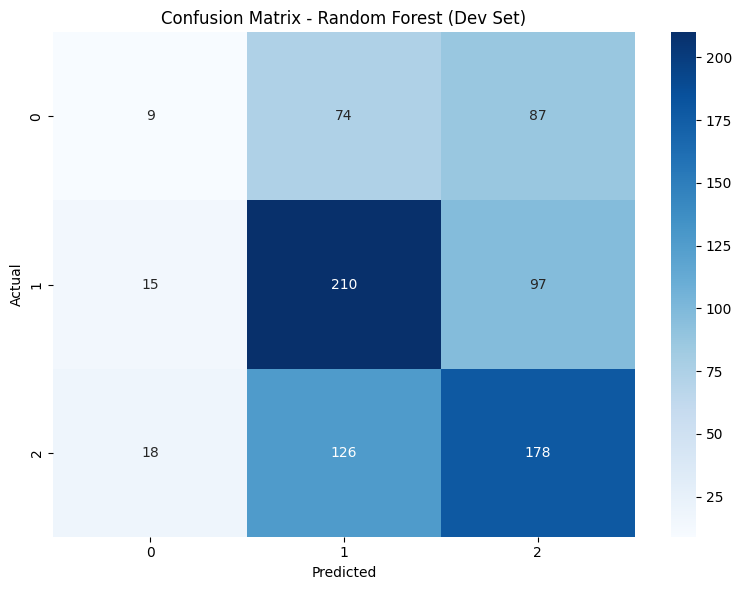

In [37]:
# Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=300, random_state=1, class_weight='balanced')

# Splitting data
train = df_model_building_all_features[df_model_building_all_features["Date"] < '2023-01-01']
dev = df_model_building_all_features[(df_model_building_all_features["Date"] >= '2023-01-01') & (df_model_building_all_features["Date"] < '2024-01-01')]
test = df_model_building_all_features[df_model_building_all_features["Date"] >= '2024-01-01']

# Print dataset sizes
total_samples = len(df_model_building_all_features)
print(f"Number of samples in train: {len(train)} ({(len(train) / total_samples * 100):.2f}%)")
print(f"Number of samples in dev: {len(dev)} ({(len(dev) / total_samples * 100):.2f}%)")
print(f"Number of samples in test: {len(test)} ({(len(test) / total_samples * 100):.2f}%)")
print()

# Define predictors
predictors = ['xG_Rolling_Avg', 'xGA_Rolling_Avg', 'Sh_Rolling_Avg', 'Possession %_Rolling_Avg','Venue_Adjusted_Points_Per_Match','H2H_Wins','H2H_Draws','H2H_Losses','H2H_Win_Percentage','GF_Rolling_Avg','GA_Rolling_Avg','CS_Rolling_Avg','Venue_Home']

# Train Random Forest model
rf.fit(train[predictors], train["Result"])

# Predict on dev set
rf_preds = rf.predict(dev[predictors])

# Evaluate performance
print(f"RF Accuracy: {accuracy_score(dev['Result'], rf_preds)}")
print()
print(f"RF Classification Report:\n", classification_report(dev["Result"], rf_preds))

# Create confusion matrix
cm_rf = confusion_matrix(dev["Result"], rf_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(dev["Result"]),
            yticklabels=np.unique(dev["Result"]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest (Dev Set)')
plt.tight_layout()
plt.show()

RF Test Set Accuracy: 0.47671568627450983

RF Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.07      0.11       208
           1       0.49      0.66      0.56       304
           2       0.48      0.57      0.52       304

    accuracy                           0.48       816
   macro avg       0.44      0.43      0.40       816
weighted avg       0.45      0.48      0.43       816



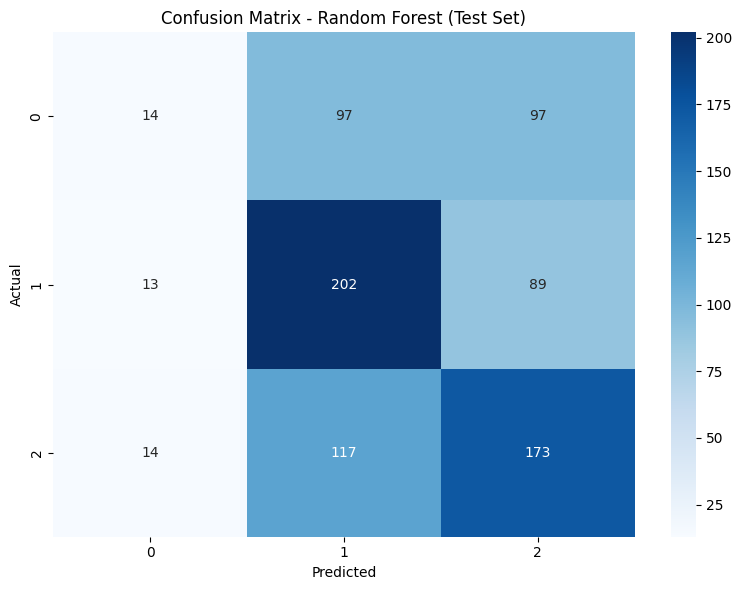

In [38]:
# Predict on test set using previously trained model
rf_test_preds = rf.predict(test[predictors])

# Evaluate test set performance
print(f"RF Test Set Accuracy: {accuracy_score(test['Result'], rf_test_preds)}")
print()
print(f"RF Test Set Classification Report:\n", classification_report(test["Result"], rf_test_preds))

# Create confusion matrix for the test set
cm_rf_test = confusion_matrix(test["Result"], rf_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(test["Result"]),
            yticklabels=np.unique(test["Result"]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest (Test Set)')
plt.tight_layout()
plt.show()

###6.2 Feature Selection Pipeline for Football Match Prediction

## Introduction
This section details a sophisticated two-phase feature selection approach designed to identify the most predictive variables for football match outcome prediction. Starting with 122 potential features, the pipeline employs statistical and machine learning techniques to systematically reduce dimensionality while maintaining predictive power.
## Methodology
### Data Splitting
The dataset was chronologically divided based on match dates to ensure temporal integrity:

1. Training set (pre-2023): 3,938 samples (70.73% of data)
2. Development set (2023): 814 samples (14.62% of data)
3. Test set (2024 and beyond): 816 samples (14.66% of data)

This time-based split prevents data leakage and simulates real-world prediction scenarios.
## Phase 1: Initial Feature Importance Screening
A preliminary Random Forest model was trained with:

- 100 decision trees (n_estimators=100)
- Class balancing to address outcome distribution imbalance
- All 122 available features

Analysis of feature importance scores revealed that team quality differentials, possession metrics, and shooting efficiency were particularly influential. The top 20 features by importance include:

1. **Team Quality Metrics**:

- FIFA Overall Rating Diff (0.0212)
- FIFA Midfield Rating Diff (0.0175)
- FIFA Defense Rating Diff (0.0161)
- FIFA Attack Rating Diff (0.0132)


2. **Performance Differentials**:

- Opponent_Goal_Difference_Before_Match (0.0134)
- Goal_Difference_Comparison_Before_Match (0.0121)
- Season_Points_Comparison_Before_Match (0.0114)


3. **Technical Performance Metrics**:

- SoT% Rolling Average (0.0130)
- Distance Covered Rolling Average (0.0119)
- Touches in Attacking Third Rolling Average (0.0117)
- Defensive Success Metrics (% of Dribblers Tackled, Save%)
- Passing Metrics (Long Pass Completions, Short Pass Completion %)



The top 40 features were selected for further refinement in the second phase.
##Phase 2: Recursive Feature Elimination with Cross-Validation (RFECV)
RFECV was implemented with:

1. Base Random Forest classifier (100 trees)
2. 5-fold cross-validation
3. Balanced accuracy scoring metric
4. Step-by-step feature elimination (step=1)
5. Parallel processing for computational efficiency

This methodical process identified the optimal feature subset from among the 40 pre-selected features.
##Results
The pipeline successfully reduced the feature space from 122 potential predictors to a more manageable and interpretable subset, identifying the most relevant features for match outcome prediction. The output includes:

- Optimal number of features determined through cross-validation
- List of specific features selected for the final model
- Storage of these features in the 'best_features' variable for subsequent modeling

##Observations and Insights

1. **Team Quality Dominance**: FIFA rating differentials emerged as the most influential predictors, suggesting that relative team strength is a primary driver of match outcomes.
2. **Form and Momentum Importance**: Pre-match performance metrics (goal differentials, points comparisons) demonstrated significant predictive power.
3. **Technical Metrics Value**: Shooting accuracy (SoT%), possession location (touches in attacking third), and defensive metrics showed meaningful contribution to outcome prediction.
4. **Balanced Indicator Types**: The selected features represent a mix of:

- Quality differentials (FIFA ratings)
- Historical performance (rolling averages)
- Match context (relative standings)
- Technical performance metrics (passing, shooting, defensive actions)



##Conclusion
This comprehensive feature selection pipeline demonstrates a methodical approach to dimensionality reduction for football match prediction. By combining statistical screening with machine learning-based optimization, the process identifies a subset of features that captures the most predictive signals while improving model interpretability and computational efficiency.
The selected features provide valuable insights into the key drivers of match outcomes and establish a solid foundation for subsequent predictive modeling efforts.



Number of samples in train: 3938 (70.73%)
Number of samples in dev: 814 (14.62%)
Number of samples in test: 816 (14.66%)

Total features available: 122
Running initial feature importance screening...
Top 20 features by importance:
1. FIFA Overall Rating Diff: 0.0212
2. FIFA Midfield Rating Diff: 0.0175
3. FIFA Defense Rating Diff: 0.0161
4. Opponent_Goal_Difference_Before_Match: 0.0134
5. FIFA Attack Rating Diff: 0.0132
6. SoT%_Rolling_Avg: 0.0130
7. Goal_Difference_Comparison_Before_Match: 0.0121
8. Dist_Rolling_Avg: 0.0119
9. Touches (Att 3rd)_Rolling_Avg: 0.0117
10. Season_Points_Comparison_Before_Match: 0.0114
11. % of Dribblers Tackled_Rolling_Avg: 0.0113
12. Save%_Rolling_Avg: 0.0112
13. Opponent FIFA Attack Rating: 0.0110
14. Long Pass Cmp_Rolling_Avg: 0.0109
15. Short Pass Cmp%_Rolling_Avg: 0.0108
16. Total Carrying Distance_Rolling_Avg: 0.0108
17. Clearances_Rolling_Avg: 0.0108
18. Interceptions_Rolling_Avg: 0.0107
19. Touches (Att Pen)_Rolling_Avg: 0.0104
20. Short Pass Cmp_R

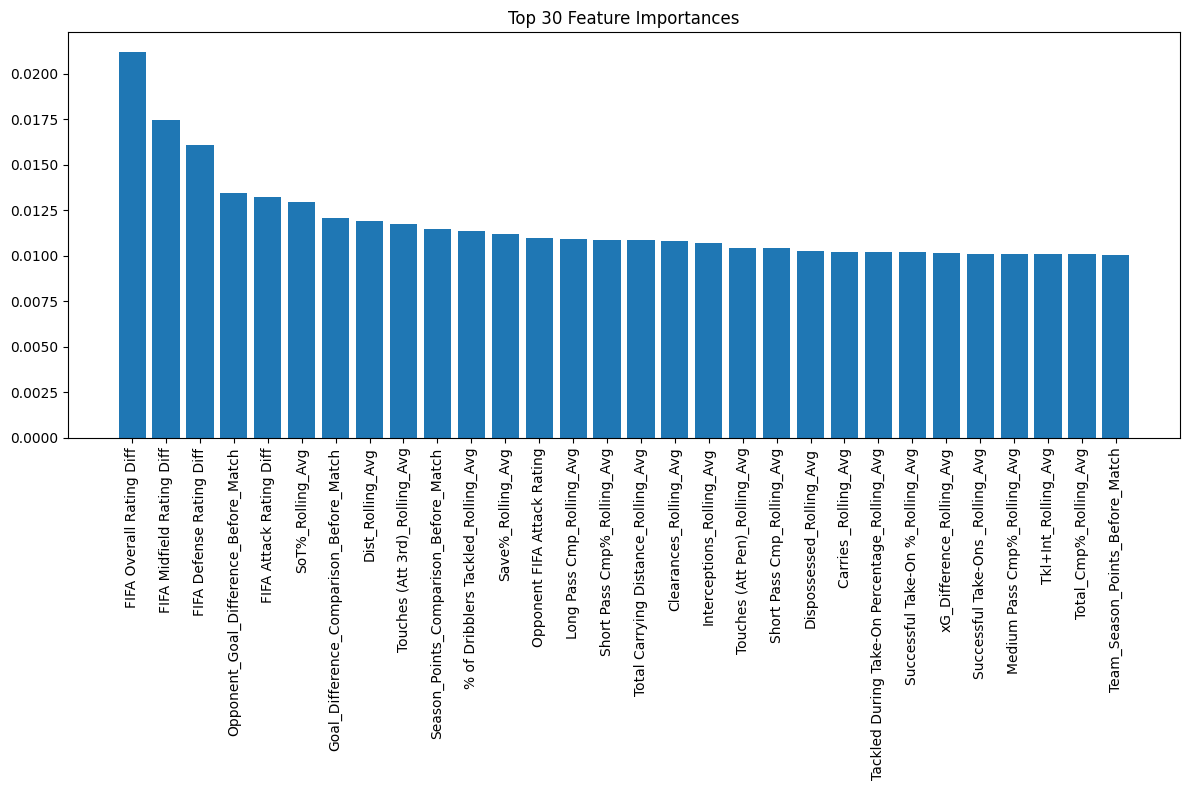


Selected top 40 features for RFECV

Performing RFECV to find optimal feature subset...
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Optimal number of features: 26
Selected features:
- FIFA Overall Rating Diff
- FIFA Midfield Rating Diff
- FIFA Defense Rating Diff
- Opponent_Goal_Difference_Before_Match
- SoT%_Rolling_Avg
- Goal_Difference_Comparison_Before_Match
- Dist_Rolling_Avg
- Touches (Att 3rd)_Rolling_Avg
- % of Dribblers Tackled_Rolling_Avg
- Save%_Rolling_Avg
- Long Pass Cmp_Rolling_Avg
- Short Pass Cmp%_Rolling_Avg
- Total C

In [39]:
# Splitting data from df_model_building_all_features
train = df_model_building_all_features[df_model_building_all_features["Date"] < '2023-01-01']
dev = df_model_building_all_features[(df_model_building_all_features["Date"] >= '2023-01-01') & (df_model_building_all_features["Date"] < '2024-01-01')]
test = df_model_building_all_features[df_model_building_all_features["Date"] >= '2024-01-01']

# Print dataset sizes
total_samples = len(df_model_building_all_features)
print(f"Number of samples in train: {len(train)} ({(len(train) / total_samples * 100):.2f}%)")
print(f"Number of samples in dev: {len(dev)} ({(len(dev) / total_samples * 100):.2f}%)")
print(f"Number of samples in test: {len(test)} ({(len(test) / total_samples * 100):.2f}%)")
print()

# Get all feature columns except 'Result' and 'Date'
all_predictors = [col for col in df_model_building_all_features.columns
                 if col not in ['Result', 'Date']]

print(f"Total features available: {len(all_predictors)}")

# 1. Initial feature importance screening
print("Running initial feature importance screening...")
rf_base = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
rf_base.fit(train[all_predictors], train["Result"])

# Get feature importances
importances = rf_base.feature_importances_
indices = np.argsort(importances)[::-1]

# Print top 20 most important features
print("Top 20 features by importance:")
for i in range(min(20, len(all_predictors))):
    print(f"{i+1}. {all_predictors[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot top 30 features
plt.figure(figsize=(12, 8))
plt.title("Top 30 Feature Importances")
plt.bar(range(30), importances[indices[:30]], align="center")
plt.xticks(range(30), [all_predictors[i] for i in indices[:30]], rotation=90)
plt.tight_layout()
plt.show()

# Select top 40 features for RFECV (for computational efficiency)
top_features = [all_predictors[i] for i in indices[:40]]
print(f"\nSelected top 40 features for RFECV")

# 2. Recursive Feature Elimination with Cross-Validation
print("\nPerforming RFECV to find optimal feature subset...")
rfecv = RFECV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced'),
    step=1,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

rfecv.fit(train[top_features], train["Result"])

print(f"Optimal number of features: {rfecv.n_features_}")
selected_features = [top_features[i] for i in range(len(top_features)) if rfecv.support_[i]]
print("Selected features:")
for feature in selected_features:
    print(f"- {feature}")

# Store the selected features in a variable that will be available for the next code chunk
best_features = selected_features
print(f"\nBest features stored in variable 'best_features'")
print(f"Total of {len(best_features)} features selected")

### 6.3 Hyperparameter-Tuned Random Forest for Football Match Prediction

##Introduction
This section details the implementation of an optimized Random Forest classification model for predicting football match outcomes. Building upon the previous feature selection pipeline, this approach employs systematic hyperparameter tuning to enhance predictive performance using the 26 most informative features identified earlier.
##Methodology
###Feature Selection Foundation
The model leveraged the 26 optimal features determined through the two-phase feature selection process (initial screening and RFECV), providing a solid foundation of predictive variables.
###Hyperparameter Optimization
A comprehensive grid search was implemented with:

- 216 parameter combinations evaluated across 5-fold cross-validation (1,080 total fits)


Parameter grid exploration:
1. n_estimators: [100, 200, 300, 400]
2. max_depth: [None, 30, 40]
3. min_samples_split: [2, 10, 15]
4. min_samples_leaf: [1, 5, 7]
5. class_weight: ['balanced', 'balanced_subsample']


- Balanced accuracy scoring metric to address class imbalance
- Parallel processing for computational efficiency

##Optimal Configuration
Grid search identified the following optimal parameters:

- n_estimators: 100
- max_depth: None (allowing trees to grow to their full depth)
- min_samples_leaf: 7
- min_samples_split: 2
- class_weight: 'balanced'

This configuration achieved a cross-validation balanced accuracy score of 0.4649.
##Performance Results
###Development Set (2023 matches)

- Accuracy: 52.09%


Class-specific performance:
1. Draws (0): Poor prediction capability with only 6% recall and 18% precision
2. Losses (1): Good performance with 65% recall and 56% precision
3. Wins (2): Good performance with 63% recall and 54% precision



###Test Set (2024 matches)

- Accuracy: 54.04%


Class-specific performance:

1. Draws (0): Improved but still challenging, with 13% recall and 39% precision
2. Losses (1): Strong performance with 68% recall and 58% precision
3. Wins (2): Strong performance with 68% recall and 53% precision



##Key Observations

1. **Performance Improvement**: The hyperparameter-tuned model achieved substantially higher accuracy than the base model, with a 52.09% accuracy on the development set and 54.04% on the test set.

2. **Test Set Outperformance**: Interestingly, the model performed better on future data (test set) than on the development set, suggesting good generalization and possibly indicating that 2024 matches may have more predictable patterns.
Class Imbalance Challenges: Despite using balanced class weights, predicting draws remained challenging, though draw prediction performance improved notably in the test set.

3. **Strong Win/Loss Prediction**: The model demonstrated robust capability in predicting wins and losses, with particularly strong recall rates of 68% for both classes in the test set.
Optimal Model Simplicity: The best model used only 100 trees, suggesting that additional trees did not improve predictive performance and might have introduced overfitting.

##Conclusion
The hyperparameter-tuned Random Forest model demonstrates significantly improved predictive performance for football match outcomes compared to baseline approaches. With overall accuracy exceeding 54% on unseen test data in a three-class prediction problem, the model provides valuable predictive capability for match outcome forecasting.

The consistent improvement in test set performance indicates robust generalization capabilities and suggests the model has captured meaningful patterns in football match dynamics. While draw prediction remains challenging, the model shows strong capability in correctly identifying wins and losses.



Using 26 selected features for model training
Running GridSearchCV with the optimal feature set...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': np.int64(100)}
Best cross-validation score: 0.4649

--- DEV SET EVALUATION ---
Accuracy: 0.5209
Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.06      0.10       170
           1       0.56      0.65      0.60       322
           2       0.54      0.63      0.58       322

    accuracy                           0.52       814
   macro avg       0.43      0.45      0.43       814
weighted avg       0.47      0.52      0.49       814



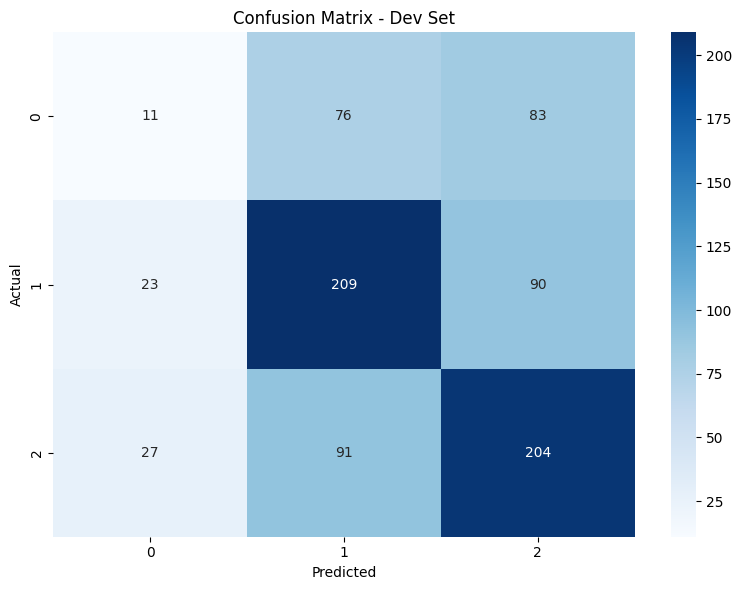


--- TEST SET EVALUATION ---
Accuracy: 0.5404
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.13      0.19       208
           1       0.58      0.68      0.62       304
           2       0.53      0.68      0.60       304

    accuracy                           0.54       816
   macro avg       0.50      0.50      0.47       816
weighted avg       0.51      0.54      0.51       816



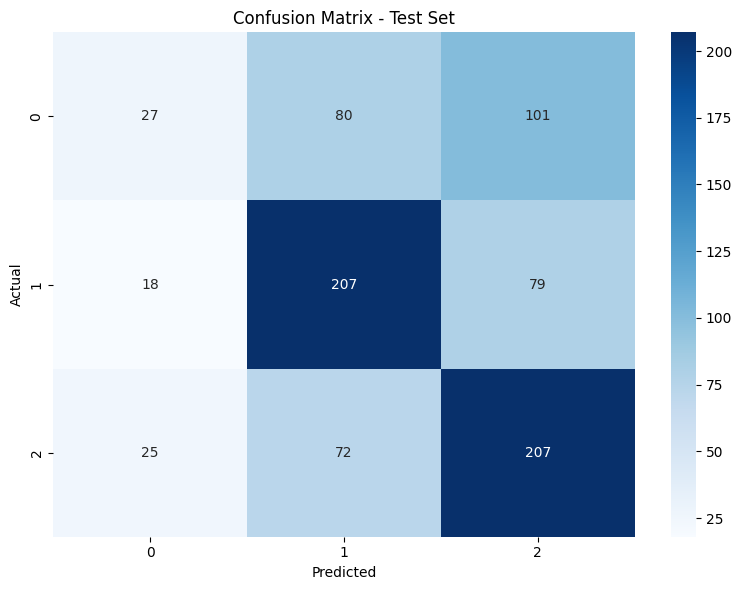

In [43]:
# Use the best_features from the previous code chunk
print(f"Using {len(best_features)} selected features for model training")

# Hyperparameter tuning with GridSearchCV
print("Running GridSearchCV with the optimal feature set...")
param_grid = {
    'n_estimators': np.arange(100, 500, 100),  # Reduced grid size for computability
    'max_depth': [None, 30, 40],
    'min_samples_split': [2, 10, 15],
    'min_samples_leaf': [1, 5, 7],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(train[best_features], train["Result"])
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_rf = grid_search.best_estimator_

# DEV SET EVALUATION
print("\n--- DEV SET EVALUATION ---")
# Predict on dev set
dev_preds = best_rf.predict(dev[best_features])
print(f"Accuracy: {accuracy_score(dev['Result'], dev_preds):.4f}")
print(f"Classification Report:\n{classification_report(dev['Result'], dev_preds)}")

# Create confusion matrix for dev set
plt.figure(figsize=(8, 6))
cm = confusion_matrix(dev["Result"], dev_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(dev["Result"]),
            yticklabels=np.unique(dev["Result"]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Dev Set')
plt.tight_layout()
plt.show()

# TEST SET EVALUATION
print("\n--- TEST SET EVALUATION ---")
# Predict on test set
test_preds = best_rf.predict(test[best_features])
print(f"Accuracy: {accuracy_score(test['Result'], test_preds):.4f}")
print(f"Classification Report:\n{classification_report(test['Result'], test_preds)}")

# Create confusion matrix for test set
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(test["Result"], test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(test["Result"]),
            yticklabels=np.unique(test["Result"]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

### 6.3.1 Feature Importance

####Horizontal Bar Chart of Feature Importance with Standard Deviation
Code Purpose:

- Calculates feature importances using the Random Forest’s feature_importances_ attribute.

- Computes standard deviation of importances across individual trees to show stability.

- Ranks and visualizes the top 15 features.

#####Top Features:

1. FIFA Overall Rating Diff (highest importance)

2. FIFA Defense Rating Diff

3. Goal_Difference_Comparison_Before_Match

#####Low Variance Features:

Save%_Rolling_Avg and % of Dribblers Tackled_Rolling_Avg have small error bars, indicating consistent importance across trees.

#####Interpretation:

FIFA team ratings and goal difference trends are critical predictors, while passing metrics (Long Pass Cmp) contribute less.

####Feature Importance Heatmap by Class
Code Purpose:

- Trains separate mini-Random Forest models for each class (Win/Loss/Draw) to identify class-specific feature importance.

- Visualizes how features drive predictions for each outcome.

####Class-Specific Patterns:

- Draws (Class 0): Weakly influenced by all features (low importance scores <0.05).

- Losses (Class 1): Heavily driven by FIFA Overall Rating Diff (0.059) and defensive metrics.

- Wins (Class 2): Similar to losses but with slightly balanced weights.

####Takeaway:
Draws lack clear feature signals, explaining their poor recall.

#### Permutation vs. MDI Feature Importance
Code Purpose:

- Compares Model-based (MDI) importance (tree splits) with Permutation importance (performance drop when features are shuffled).

- Identifies overrated/underrated features by the model.

#####Key Observations
1. **High Agreement**: FIFA Overall Rating Diff and Goal_Difference_Comparison rank highly in both metrics.

2. **Divergence**: Short Pass Cmp%_Rolling_Avg has high MDI but low permutation importance – the model overvalues it. xG_Difference_Rolling_Avg is undervalued by MDI but critical for permutation.

3. **Action**: Prioritize features with high permutation importance (e.g., xG_Difference) for model robustness.





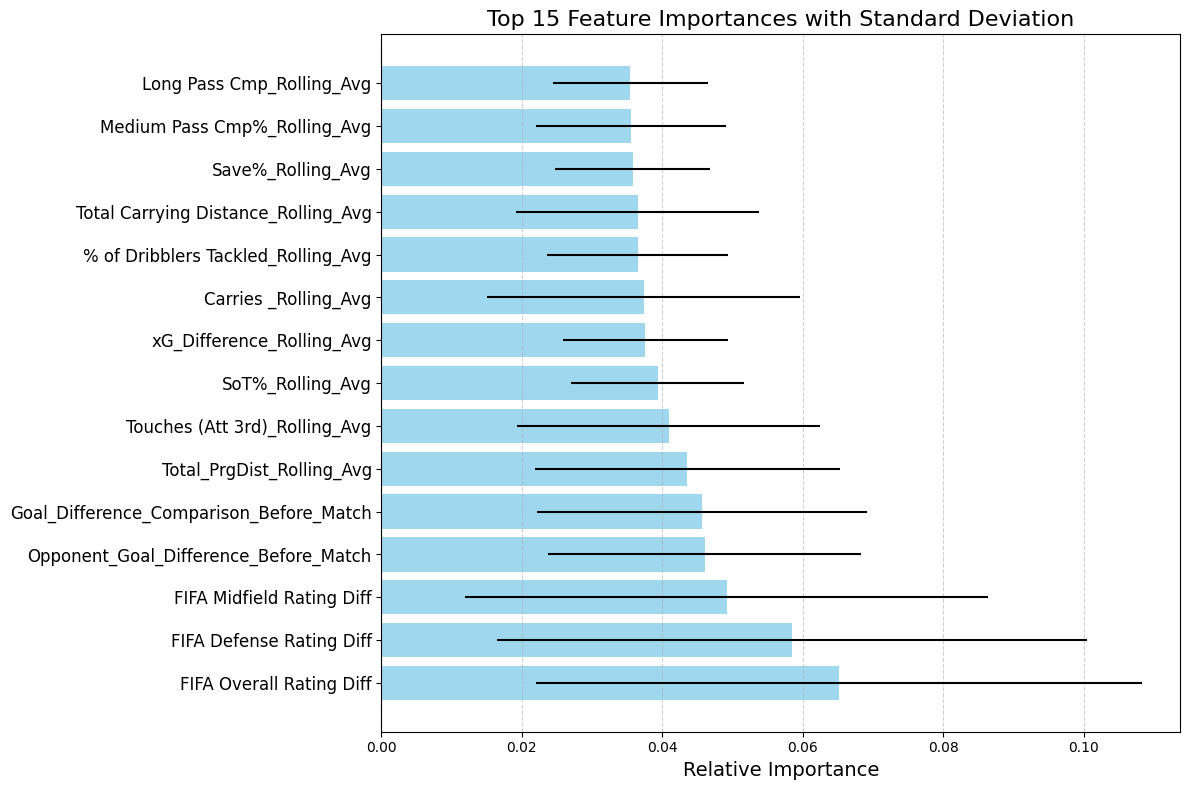

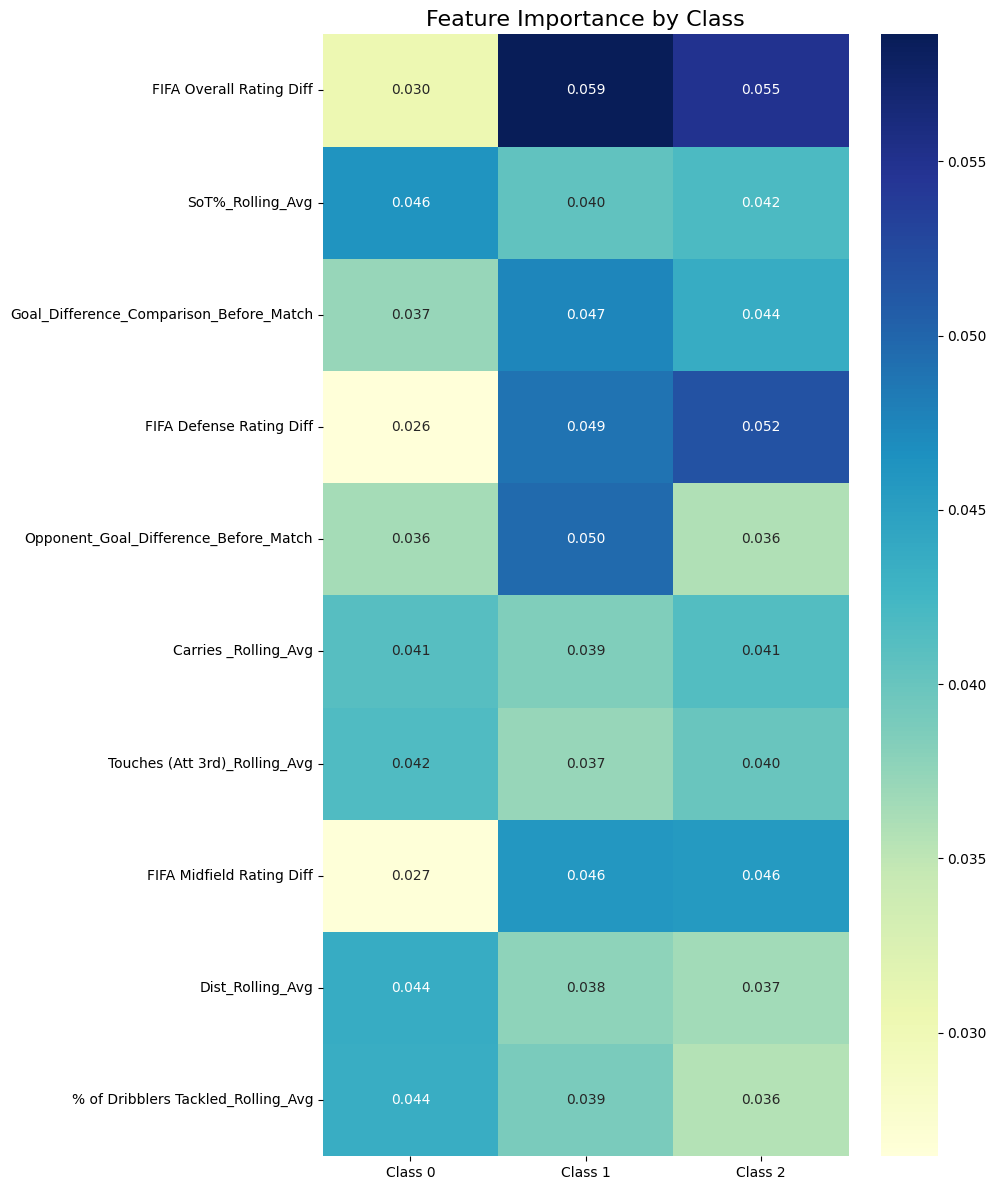

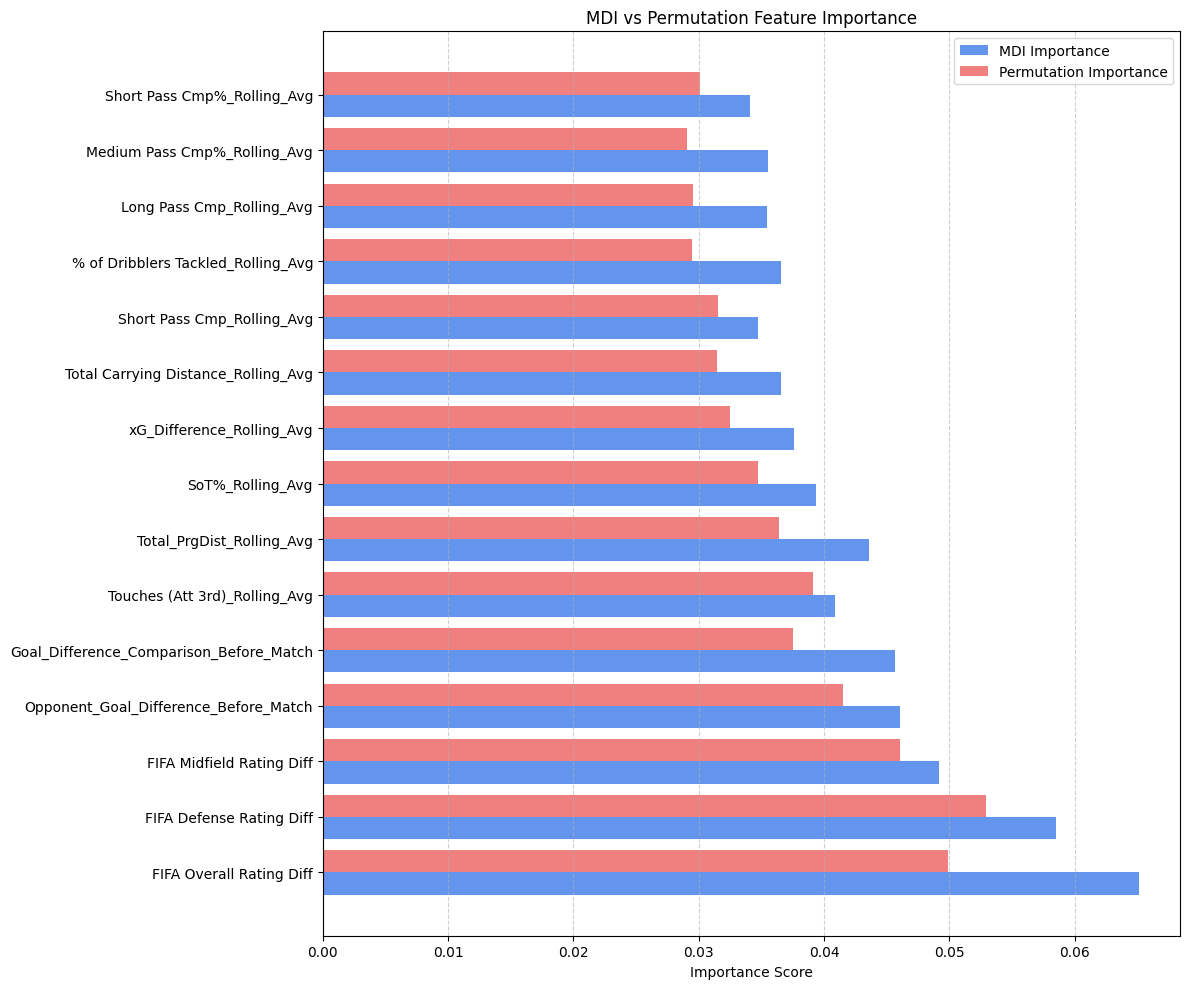

In [46]:
# 1. Horizontal Bar Chart of Feature Importance with Standard Deviation
def plot_feature_importance_with_std(model, feature_names, top_n=15):
    """Plot feature importance with error bars showing variance across trees."""
    # Get feature importances with their standard deviations
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    # Sort by importance
    indices = np.argsort(importances)[::-1][:top_n]

    # Plot
    plt.figure(figsize=(12, 8))
    plt.title(f'Top {top_n} Feature Importances with Standard Deviation', fontsize=16)
    plt.barh(range(len(indices)), importances[indices], color='skyblue',
             xerr=std[indices], align='center', alpha=0.8)
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=12)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    return plt

# 2. Feature Importance Heatmap by Class
def plot_feature_importance_by_class(model, feature_names, train_data, target_column, top_n=10):
    """Plot a heatmap showing how feature importance varies across different target classes."""
    # Get unique classes
    classes = np.unique(train_data[target_column])

    # Create a DataFrame to store importance for each class
    importance_by_class = pd.DataFrame(index=feature_names)

    # For each class, calculate feature importance on that subset
    for class_value in classes:
        # Create binary target: 1 for current class, 0 for others
        binary_target = (train_data[target_column] == class_value).astype(int)

        # Train a small forest for this class
        temp_model = RandomForestClassifier(n_estimators=50, random_state=1)
        temp_model.fit(train_data[feature_names], binary_target)

        # Store importances
        importance_by_class[f'Class {class_value}'] = temp_model.feature_importances_

    # Sort by average importance
    importance_by_class['Average'] = importance_by_class.mean(axis=1)
    importance_by_class = importance_by_class.sort_values('Average', ascending=False).drop('Average', axis=1).head(top_n)

    # Plot heatmap
    plt.figure(figsize=(10, 12))
    sns.heatmap(importance_by_class, cmap='YlGnBu', annot=True, fmt='.3f')
    plt.title('Feature Importance by Class', fontsize=16)
    plt.tight_layout()
    return plt

# 3. Permutation Importance vs. MDI Importance
def plot_permutation_vs_mdi_importance(model, X, y, feature_names, top_n=15):
    """
    Compare Model-based (MDI) importance vs. Permutation importance.
    Permutation importance shows importance based on performance drop when features are shuffled.
    """
    # Calculate permutation importance
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=1)

    # Get model-based importance (MDI)
    mdi_importance = model.feature_importances_

    # Create DataFrame for both metrics
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'MDI Importance': mdi_importance,
        'Permutation Importance': perm_importance.importances_mean
    })

    # Sort by average of both importance metrics
    importance_df['Average'] = importance_df[['MDI Importance', 'Permutation Importance']].mean(axis=1)
    importance_df = importance_df.sort_values('Average', ascending=False).drop('Average', axis=1).head(top_n)

    # Prepare data for plotting
    features_to_plot = importance_df['Feature'].values
    mdi_values = importance_df['MDI Importance'].values
    perm_values = importance_df['Permutation Importance'].values

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Set width of bars
    barWidth = 0.4

    # Set position of bars on X axis
    r1 = np.arange(len(features_to_plot))
    r2 = [x + barWidth for x in r1]

    # Create bars
    ax.barh(r1, mdi_values, barWidth, color='cornflowerblue', label='MDI Importance')
    ax.barh(r2, perm_values, barWidth, color='lightcoral', label='Permutation Importance')

    # Add labels and title
    ax.set_yticks([r + barWidth/2 for r in range(len(features_to_plot))])
    ax.set_yticklabels(features_to_plot)
    ax.set_xlabel('Importance Score')
    ax.set_title('MDI vs Permutation Feature Importance')
    ax.legend()

    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    return plt

# Visualization 1: Standard feature importance with standard deviation
plot1 = plot_feature_importance_with_std(best_rf, best_features)
plot1.savefig('feature_importance_with_std.png', dpi=300, bbox_inches='tight')
plot1.show()

# Visualization 2: Feature importance by class
plot2 = plot_feature_importance_by_class(best_rf, best_features, train, "Result")
plot2.savefig('feature_importance_by_class.png', dpi=300, bbox_inches='tight')
plot2.show()

# Visualization 3: Permutation vs MDI importance
plot3 = plot_permutation_vs_mdi_importance(best_rf, train[best_features], train["Result"], best_features)
plot3.savefig('permutation_vs_mdi_importance.png', dpi=300, bbox_inches='tight')
plot3.show()